In [1]:
import os, sys, time
import numpy as np
from numpy import sqrt, exp, pi, square
import pandas as pd
pd.options.mode.chained_assignment = None        # default='warn'
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d, UnivariateSpline
import warnings
warnings.filterwarnings('ignore')
from multihist import Histdd, Hist1d
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from contextlib import contextmanager

def plt_config(title=None, xlim=None, ylim=None, xlabel=None, ylabel=None, colorbar=False, sci=False, art=plt):
    for field in ['title', 'xlim', 'ylim', 'xlabel', 'ylabel']:
        if eval(field) != None: getattr(art, field)(eval(field))
    if isinstance(sci, str): art.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if isinstance(colorbar,str): art.colorbar(label=colorbar)
    elif colorbar: art.colorbar(label = '$Number\ of\ Entries$')

@contextmanager
def initiate_plot(dimx=24, dimy=9):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    global fig; fig = plt.figure()
    yield
    plt.show()

In [2]:
import hax
hax.__version__

hax.init(raw_data_access_mode = 'local',
         raw_data_local_path = ['/project/lgrandi/xenon1t/raw_for_waveforms/'], 
         main_data_paths= ['/project2/lgrandi/xenon1t/processed/pax_v6.10.0/',''],
         minitree_paths= ['/scratch/midway2/zhut/data/SingleScatter/data/minitrees/'],
         pax_version_policy = 'loose',
         use_rundb=True,
         make_minitree=True,
         minitree_caching=False,)

In [28]:
import pickle
with open('/project2/lgrandi/zhut/s2_single_classifier_gmix_v6.10.0.pkl', 'rb') as f:
    gmix=pickle.load(f)

def classify(df):
    df['CutS2SingleScatterHE'] = 0

    Y = np.concatenate([np.log10(df.loc[:,['area', 'goodness_of_fit_tpf', 's2']])], axis=1)
    df.loc[:, 'CutS2SingleScatterHE'] = gmix.predict(Y)
    df.loc[:, 'CutS2SingleScatterHE'] = np.array(df.CutS2SingleScatterHE, bool)
    return df

In [4]:
from hax.minitrees import TreeMaker

class MultipleS2Peaks(TreeMaker):
    __version__ = '6.0.0'
    extra_branches = ['peaks.*']
    
    sample_duration = 10 # ns
    drift_time_gate = 1.7e3 # ns 
    drift_velocity_liquid = 0.0001335 # cm / ns

    def extract_data(self, event):        
        if not len(event.interactions):
            return []

        interaction = event.interactions[0]
        s1 = event.peaks[interaction.s1]
        s2 = event.peaks[interaction.s2]
        
        direct_fields = ['area', 'area_fraction_top', 'center_time', 'detector', 'index_of_maximum', 'type']

        not_direct_fields = ['goodness_of_fit_nn', 'goodness_of_fit_tpf',
            'range_50p_area', 'x_nn', 'x_tpf', 'y_nn', 'y_tpf']

        number_peaks = len(event.peaks)
        peak_data = {field: list(np.zeros(number_peaks)) for field in direct_fields+not_direct_fields}

        for peak_i, peak in enumerate(event.peaks):
            peak_data['range_50p_area'][peak_i] = list(peak.range_area_decile)[5]

            for rp in peak.reconstructed_positions:
                if rp.algorithm == 'PosRecTopPatternFit':
                    for field in ['x', 'y', 'goodness_of_fit']:
                        peak_data[field+'_tpf'][peak_i] = getattr(rp, field)

                if rp.algorithm == 'PosRecNeuralNet':
                    for field in ['x', 'y', 'goodness_of_fit']:
                        peak_data[field+'_nn'][peak_i] = getattr(rp, field)

            for field in direct_fields:
                peak_data[field][peak_i] = getattr(peak, field)

        peaks = pd.DataFrame(peak_data)
        peaks = peaks[peaks.eval('(type=="s2") & (detector == "tpc") & (area>150)')]
        
        if len(peaks) < 1:
            return []
        
        peaks['event_number'] = event.event_number
        peaks['run_number'] = self.run_number
        peaks['drift_time'] = (peaks.index_of_maximum - s1.index_of_maximum) * MultipleS2Peaks.sample_duration
        peaks['z'] = - MultipleS2Peaks.drift_velocity_liquid * (peaks['drift_time'] - MultipleS2Peaks.drift_time_gate)
        
        # Make sure it's possible for being an interation with S1
        # (1) The paired z position is in TPC
        peaks = peaks[peaks.eval('(z < 0) & (z > -100)')]
         
        # (2) The s2 has a good pattern
        peaks['s2'] = s2.area x
        peaks = classify(peaks)
        peaks = peaks[~peaks.CutS2SingleScatterHE]
        
        # (3) The s2 width fit drift model
        # (4) The s2 width fit drift model
        
        
        return peaks.to_dict('records')

    def process_event(self, event):
        result = self.extract_data(event)
        if not isinstance(result, (list, tuple)):
            raise TypeError("MultipleRowExtractor treemakers must extract "
                            "a list of dictionaries, not a %s" % type(result))
        # Add the run and event number to the result. This is required to make joins succeed later on.
        assert len(result) == 0 or isinstance(result[0], dict)
        self.cache.extend(result)
        self.check_cache()


In [5]:
run_names = [f[:11] for f in os.listdir(hax.config['main_data_paths'][0]) if '.root' in f]

In [9]:
df_ms_peaks, _ = hax.minitrees.load_single_dataset(run_names[0], [MultipleS2Peaks])

Run 170804_0004: Making MultipleS2Peaks minitree: 100%|██████████| 18894/18894 [06:25<00:00, 49.01it/s]


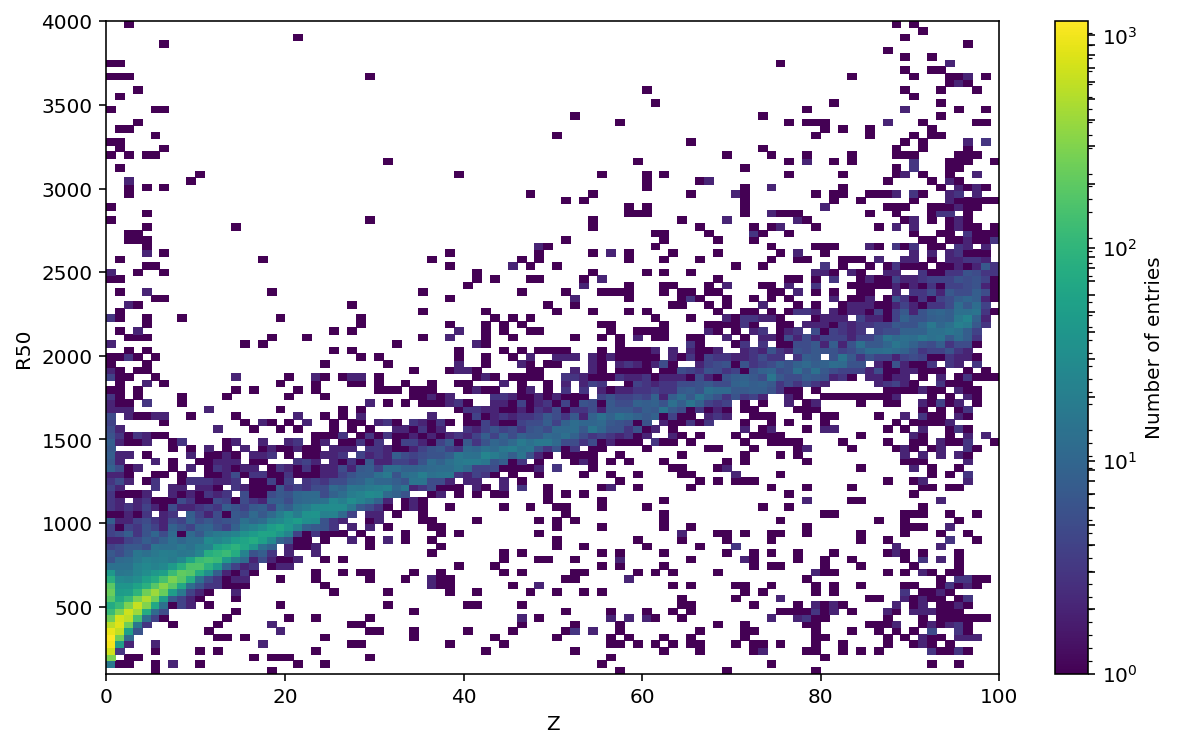

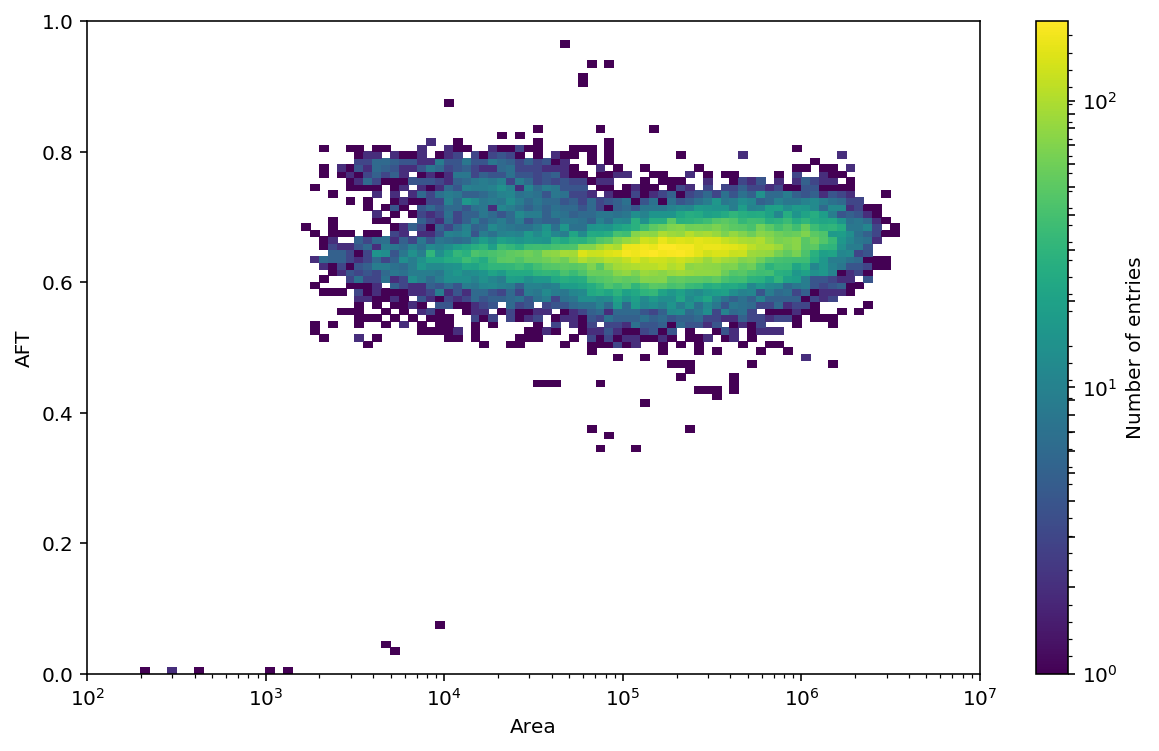

In [29]:
with initiate_plot(10, 6):
    argx, argy = '-{df}.z', '{df}.range_50p_area'
    mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
                bins = [np.linspace(0, 100, 101), np.linspace(100, 4000, 101)]
            )
    mh.plot(log_scale = True)
    plt_config(xlabel='Z', ylabel='R50')

with initiate_plot(10, 6):
    argx, argy = '{df}.area', '{df}.area_fraction_top'
    mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
                bins = [np.logspace(2, 7, 101), np.linspace(0, 1, 101)]
            )
    mh.plot(log_scale = True)
    plt.xscale('log')
    plt_config(xlabel='Area', ylabel='AFT')